### Stock Market Prediction And Forecasting Using Stacked LSTM

By: ZaraPhCode

Importing modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math

import data from <code>csv</code> file into pandas dataframe:

In [2]:
df = pd.read_csv('NSE_TATAGLOBAL.csv')

Lets take a look at the data:

In [4]:
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


Here we only use the <code>Close</code> data to fit our model. So, we make a new series where contains the close data:

In [3]:
df_close = df['Close']

In [4]:
df_close

0       233.75
1       233.25
2       234.25
3       236.10
4       233.30
         ...  
2030    118.65
2031    117.60
2032    120.65
2033    120.90
2034    121.55
Name: Close, Length: 2035, dtype: float64

Lets plot the data:

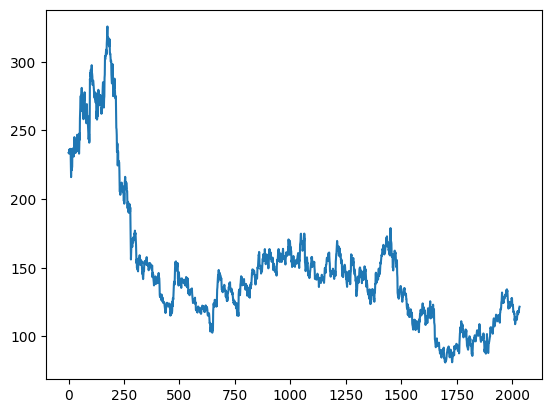

In [5]:
plt.plot(df_close)

Here, we scale the data using <code>MinMaxScaler</code>:

In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
df_close = scaler.fit_transform(np.array(df_close).reshape(-1,1))

Lets see the normalized data:

In [7]:
print(df_close)

[[0.62418301]
 [0.62214052]
 [0.62622549]
 ...
 [0.1621732 ]
 [0.16319444]
 [0.16584967]]


Here, we split our dataset into train and test sets:

In [8]:
training_size = int(len(df_close)*0.7)
test_size = len(df_close) - training_size
train_data , test_data = df_close[0:training_size,:] , df_close[training_size:len(df_close),:1]

lets see the size of each dataset:

In [9]:
print(training_size)
print(test_size)

1424
611


Here we create data sets X and the associated Y:

In [10]:
def create_dataset(data , time_step = 1):
	dataX , dataY = [] , []
	for i in range(len(data) - time_step - 1) :
		a = data[i:(i+time_step) , 0] 
		dataX.append(a)
		dataY.append(data[i + time_step , 0])
	return np.array(dataX) , np.array(dataY)

Reshaping the train and test dataset according to the parameter <code>timestep</code>. Here we choose <code>tiemstep</code> to be 100, so we predict the new Y data according to its 100 previous values in the series.

In [12]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

See that each row in <code>X_train</code> has all the values of its previous row except for the first item, and it also has 1 new item in its last column:

In [13]:
X_train

array([[0.62418301, 0.62214052, 0.62622549, ..., 0.83455882, 0.86213235,
        0.85273693],
       [0.62214052, 0.62622549, 0.63378268, ..., 0.86213235, 0.85273693,
        0.87111928],
       [0.62622549, 0.63378268, 0.62234477, ..., 0.85273693, 0.87111928,
        0.84497549],
       ...,
       [0.26041667, 0.2563317 , 0.24652778, ..., 0.33415033, 0.33986928,
        0.34681373],
       [0.2563317 , 0.24652778, 0.23611111, ..., 0.33986928, 0.34681373,
        0.3500817 ],
       [0.24652778, 0.23611111, 0.25204248, ..., 0.34681373, 0.3500817 ,
        0.32618464]])

See the size of each dataset:

In [14]:
print(X_train.shape)
print(y_train.shape)

(1323, 100)
(1323,)


In [15]:
print(X_test.shape)
print(ytest.shape)

(510, 100)
(510,)


We should now reshape the train and test dataset to fit the shape required for LSTM: number of data, items in each data, number of features

In [16]:
X_train = X_train.reshape(X_train.shape[0] , X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0] , X_test.shape[1] , 1)

We can now create our LSTM model: importing required modules

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

Building the model:

In [18]:
model = Sequential([
    LSTM(50 , return_sequences = True , input_shape = (100,1)),
    LSTM(50 , return_sequences = True),
    LSTM(50),
    Dense(1)
])

Compiling the model:

In [19]:
model.compile(loss = 'mean_squared_error', optimizer = 'adam')


In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


Train the model on the training set, check the validation using test set:

In [38]:
model.fit(X_train , y_train , validation_data = (X_test , ytest) , epochs = 100 , batch_size = 64 , verbose = 1)

Epoch 1/100
21/21 [==============================] - 4s 177ms/step - loss: 6.6044e-04 - val_loss: 8.0756e-04
Epoch 2/100
21/21 [==============================] - 4s 176ms/step - loss: 5.6921e-04 - val_loss: 6.1903e-04
Epoch 3/100
21/21 [==============================] - 4s 176ms/step - loss: 6.0117e-04 - val_loss: 5.6598e-04
Epoch 4/100
21/21 [==============================] - 4s 176ms/step - loss: 6.0783e-04 - val_loss: 6.2115e-04
Epoch 5/100
21/21 [==============================] - 4s 175ms/step - loss: 5.5831e-04 - val_loss: 8.2387e-04
Epoch 6/100
21/21 [==============================] - 4s 175ms/step - loss: 5.5262e-04 - val_loss: 8.6523e-04
Epoch 7/100
21/21 [==============================] - 4s 178ms/step - loss: 5.0446e-04 - val_loss: 7.9633e-04
Epoch 8/100
21/21 [==============================] - 4s 174ms/step - loss: 5.4098e-04 - val_loss: 7.3736e-04
Epoch 9/100
21/21 [==============================] - 4s 181ms/step - loss: 5.0678e-04 - val_loss: 6.0975e-04
Epoch 10/100
21/21 

Here we get the predicted value for train and test sets:

In [39]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

16/16 [==============================] - 1s 42ms/step


transforming the predicted data into original non-normalized values:

In [40]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

Evaluate the predictions using mean squared error metrics.

for the training set:

In [41]:
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train , train_predict))

164.21784436276107

and for the test set:

In [42]:
math.sqrt(mean_squared_error(ytest,test_predict))

105.89741372332868

Here we plot the original data, along with the predicted values for the training set, and test set:

Note that we splitted the train and test set such that the first 70% portion of the data was the trining set and the last 30% portion was associated with the test set.

Note also that we predict each price according to its 100 previous values so the training set prediction starts at the 100th item.

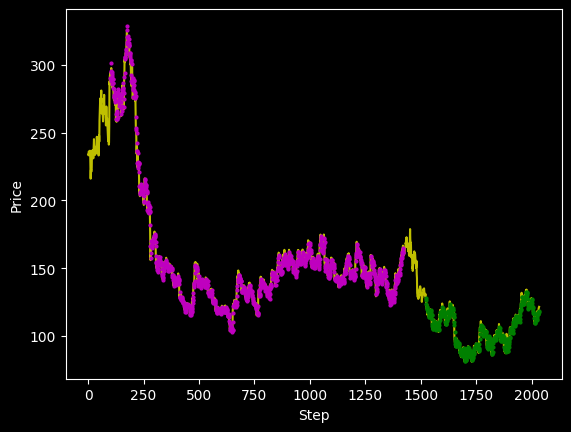

In [70]:
look_back = 100
trainPlot = np.empty_like(df_close)
trainPlot[: , :] = np.nan
trainPlot[look_back : len(train_predict) + look_back , :] = train_predict

testPlot = np.empty_like(df_close)
testPlot[: , :] = np.nan
testPlot[len(train_predict) + (look_back * 2) + 1 : len(df_close) -1, :] = test_predict

with plt.style.context(('dark_background')):
    plt.plot(scaler.inverse_transform(df_close) , 'y')
    plt.plot(trainPlot ,'mo' , markersize = 2)
    plt.plot(testPlot,'go' , markersize = 2)
    plt.xlabel('Step')
    plt.ylabel('Price')
plt.show()

In order to predict the future price, we need the last 100 values in the test set:.
lets see the number of itmes in the test set:

In [44]:
len(test_data)

611

lets now extract the last 100 values required to make prediction:

In [45]:
x_input = test_data[511:].reshape(1,-1)
x_input.shape


(1, 100)

In [46]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [47]:
temp_input

[0.12479575163398693,
 0.1384803921568627,
 0.14011437908496732,
 0.1388888888888889,
 0.13541666666666663,
 0.14011437908496732,
 0.13807189542483655,
 0.130718954248366,
 0.130718954248366,
 0.12867647058823528,
 0.11846405228758167,
 0.14644607843137253,
 0.1480800653594771,
 0.159109477124183,
 0.15992647058823523,
 0.1578839869281045,
 0.16441993464052285,
 0.178921568627451,
 0.17933006535947704,
 0.19260620915032678,
 0.2081290849673203,
 0.18974673202614378,
 0.18055555555555558,
 0.1823937908496731,
 0.17708333333333326,
 0.17810457516339862,
 0.18055555555555558,
 0.17810457516339862,
 0.17851307189542487,
 0.196078431372549,
 0.18913398692810457,
 0.1895424836601307,
 0.19403594771241828,
 0.19444444444444442,
 0.20200163398692816,
 0.19771241830065356,
 0.19934640522875813,
 0.19873366013071891,
 0.19975490196078427,
 0.21282679738562094,
 0.21568627450980393,
 0.2044526143790849,
 0.21772875816993464,
 0.21098856209150318,
 0.21425653594771243,
 0.1975081699346406,
 0.1881

prediction for the next 30 days:

In [48]:
next_ndays = []
n_steps = 100
i = 0
while(i < 30):
    
    if(len(temp_input) > 100):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1 , -1)
        x_input = x_input.reshape((1 , n_steps , 1))
        yhat = model.predict(x_input , verbose = 0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        next_ndays.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps , 1))
        yhat = model.predict(x_input , verbose = 0)
        temp_input.extend(yhat[0].tolist())
        next_ndays.extend(yhat.tolist())
        i = i + 1
    

print(lst_output)

[[0.16616597771644592], [0.16621409356594086], [0.16626077890396118], [0.1663060486316681], [0.16634997725486755], [0.1663925051689148], [0.16643384099006653], [0.1664738953113556], [0.16651275753974915], [0.1665503829717636], [0.16658690571784973], [0.1666223257780075], [0.16665664315223694], [0.1666899174451828], [0.16672225296497345], [0.16675354540348053], [0.1667838990688324], [0.16681334376335144], [0.16684189438819885], [0.16686959564685822], [0.16689640283584595], [0.16692247986793518], [0.16694772243499756], [0.16697220504283905], [0.16699589788913727], [0.16701899468898773], [0.16704128682613373], [0.16706296801567078], [0.1670839786529541], [0.16710437834262848]]


plotting the predicted price for the next 30 days:

In [49]:
day_new = np.arange(1,101)
day_pred = np.arange(101,131)

lests check the number of data in our original set <code>df_close</code> and then extract only the last 100 items required to predict the next 30 values and plt them, along with the predicted value saved in variable <code>lst_output</code>:

In [50]:
len(df_close)

2035

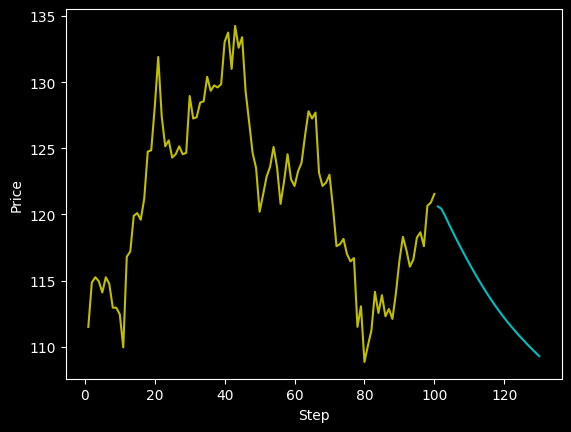

In [72]:
with plt.style.context(('dark_background')):
    plt.plot(day_new , scaler.inverse_transform(df_close[1935:]) , 'y')
    plt.plot(day_pred , scaler.inverse_transform(next_ndays) , 'c')
    plt.xlabel('Step')
    plt.ylabel('Price')
plt.show()